In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *


In [2]:
torch.cuda.set_device(2) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
# important variables
WINDOW_LENGTH = 2000 # how many samples we look at to make predictions
STEP_SIZE = 1
INPUT_DIM = 5
OUTPUT_DIM = 5

<AxesSubplot:>

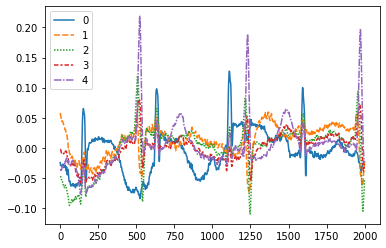

In [5]:
from sklearn.preprocessing import normalize
import seaborn as sns
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
raw_data = raw_data.astype("float32")
sns.lineplot(data = raw_data[:,0:WINDOW_LENGTH].T)

In [46]:

model = build_ts_model(InceptionTimePlus17x17, c_in=INPUT_DIM, c_out =1, seq_len = WINDOW_LENGTH, d = OUTPUT_DIM)

Dataloader

In [47]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, d,WINDOW_LENGTH,STEP_SIZE):
        'Initialization'
        self.data = d
        self.step_size = STEP_SIZE
        self.window_length = WINDOW_LENGTH
        self.num_windows = (d.shape[-1]-self.window_length-1)//self.step_size # -1 since we never predict the very last time-stamp
        
        print(self.num_windows,self.window_length,d.shape[-1])
    def __len__(self):
        'Denotes the total number of samples'
        return self.num_windows

    def __getitem__(self, index):
        'Generates one sample of data'
        n = index 
        X = self.data[:,n:n+self.window_length]
        y = self.data[:,n+self.window_length+1]

        return X, y

In [48]:
sample_size = raw_data.shape[-1]
test_length = sample_size // 550

training_set = Dataset(raw_data[:,0:test_length*4],WINDOW_LENGTH,STEP_SIZE)
training_generator = torch.utils.data.DataLoader(training_set,batch_size=8)

testing_set = Dataset(raw_data[:,test_length*4:],WINDOW_LENGTH,STEP_SIZE,)
testing_generator = torch.utils.data.DataLoader(testing_set,batch_size=128)

179 2000 2180
295819 2000 297820


Define optimizer and loss

In [49]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)

In [ ]:

best_val_loss = 1000

for epoch in range(1000):
    running_loss = 0
    for X, y in training_generator:
        X, y = X.to(device),y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    with torch.set_grad_enabled(False):
        validation_loss = 0
        for X, y in training_generator:
            X, y = X.to(device),y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            validation_loss += loss.item()
        if best_val_loss*0.99>validation_loss and epoch>200:
#             torch.save(model.state_dict(), "models/%s.ckpts"%validation_loss)
            best_val_loss = validation_loss
                
    print(f'[{epoch + 1}] train loss: {running_loss:.10f} val loss: {validation_loss:.10f}')

[1] train loss: 0.0754248446 val loss: 0.0727290257
[2] train loss: 0.0728207122 val loss: 0.0705882283
[3] train loss: 0.0707107600 val loss: 0.0686581154
[4] train loss: 0.0689506010 val loss: 0.0669785081
[5] train loss: 0.0670375432 val loss: 0.0652157672
[6] train loss: 0.0653380012 val loss: 0.0639105401
[7] train loss: 0.0645479686 val loss: 0.0648960793
[8] train loss: 0.0638521546 val loss: 0.0640383798
[9] train loss: 0.0655902969 val loss: 0.0673215489
[10] train loss: 0.0696844794 val loss: 0.0954012263
[11] train loss: 0.0873358326 val loss: 0.1015401233
[12] train loss: 0.1423143387 val loss: 0.2740256235
[13] train loss: 0.2244598783 val loss: 0.8403110857
[14] train loss: 0.7662807815 val loss: 1.1002469250
[15] train loss: 2.0529615631 val loss: 6.7850069273
[16] train loss: 4.4949835003 val loss: 16.7310238578
[17] train loss: 20.9501653742 val loss: 37.8080564290
[18] train loss: 52.4150465559 val loss: 247.4032945931
[19] train loss: 158.0621894486 val loss: 441.873

visualize a prediction chain 

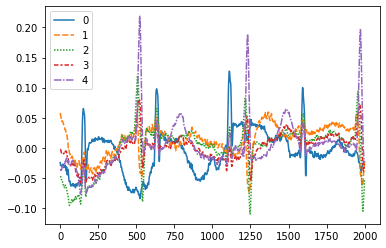

In [51]:
import seaborn as sns
X,y = next(iter(training_generator))
window = X[0].cpu()

sns.lineplot(data = window[:,0:WINDOW_LENGTH].T)
window = torch.tensor(window)

<AxesSubplot:>

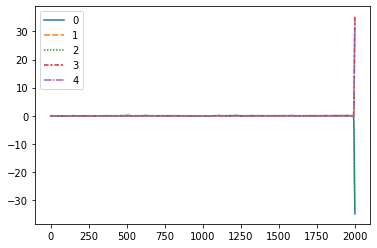

In [52]:
p_window = window.to(device)
iterations = 10
with torch.set_grad_enabled(False):
    for i in range(iterations):
        pred = model(torch.unsqueeze(p_window,dim = 0).to(device))
        p_window = torch.roll(p_window,shifts=-1,dims=1)
        p_window[:,-1] = pred
# pred = torch.squeeze(pred)

sns.lineplot(data = p_window[:,0:].T.cpu())

In [35]:
pred

TensorBase([[ 0.3267, -0.1690, -0.2926, -0.7619, -0.2890]], device='cuda:2')

In [169]:
p_window.shape

torch.Size([5, 20])